In [1]:
%pip -q install ultralytics==8.3.189 wandb roboflow onnx onnxsim "opencv-python-headless<5.0.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 87.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.8 MB/s eta 0:00:00


In [7]:
import numpy as np, sys
print("NumPy:", np.__version__)
print("Path:", np.__file__)


NumPy: 2.1.1
Path: /usr/local/lib/python3.12/dist-packages/numpy/__init__.py


In [8]:
# System + libs
!nvidia-smi -L || true

from pathlib import Path
import os, json, shutil


GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-e376cf8e-2a8a-e177-3727-2939ed8cbc6a)


Weights & Biases (W&B)

Roboflow dataset download (your exact dataset)

In [11]:
from roboflow import Roboflow
RF_API_KEY = "ouWxulB15Sf3lsOjdSQD"    # your key
WS = "roboflow-100"
PROJ = "vehicles-q0x2v"
VER  = 2

rf = Roboflow(api_key=RF_API_KEY)
project = rf.workspace(WS).project(PROJ)
version = project.version(VER)

# Prefer 'yolov8' format for Ultralytics v8 (labels are identical to v5 style)
dataset = version.download("yolov8")
DATA_DIR = Path(dataset.location)
DATA_YAML = DATA_DIR / "data.yaml"

print("Dataset at:", DATA_DIR)
print(DATA_YAML.read_text()[:400], "...")


loading Roboflow workspace...
loading Roboflow project...
Dataset at: /content/vehicles-2
names:
- big bus
- big truck
- bus-l-
- bus-s-
- car
- mid truck
- small bus
- small truck
- truck-l-
- truck-m-
- truck-s-
- truck-xl-
nc: 12
roboflow:
  license: CC BY 4.0
  project: vehicles-q0x2v
  url: https://universe.roboflow.com/roboflow-100/vehicles-q0x2v/dataset/2
  version: 2
  workspace: roboflow-100
test: ../test/images
train: ../train/images
val: ../valid/images
 ...


In [12]:
# System + libs

import os, torch, random, shutil
from pathlib import Path
from ultralytics import YOLO
from ultralytics import settings as yolo_settings


In [13]:
yaml_path = Path(dataset.location) / "data.yaml"
print("Using data.yaml ->", yaml_path)
print(yaml_path.read_text()[:400], "...")

Using data.yaml -> /content/vehicles-2/data.yaml
names:
- big bus
- big truck
- bus-l-
- bus-s-
- car
- mid truck
- small bus
- small truck
- truck-l-
- truck-m-
- truck-s-
- truck-xl-
nc: 12
roboflow:
  license: CC BY 4.0
  project: vehicles-q0x2v
  url: https://universe.roboflow.com/roboflow-100/vehicles-q0x2v/dataset/2
  version: 2
  workspace: roboflow-100
test: ../test/images
train: ../train/images
val: ../valid/images
 ...


##Train YOLOv8 + W&B logging

In [7]:
import os, wandb
from ultralytics import settings as yolo_settings

# Secure W&B login (prompts once in Colab)
wandb.login(relogin=True)

# Tell Ultralytics to use W&B internally
yolo_settings.update({'wandb': True})

# (Optional) set your W&B project/run grouping
os.environ['WANDB_PROJECT'] = 'rf-vehicles-yolov8'   # change if you like
# os.environ['WANDB_RUN_GROUP'] = 'exp1'


invalid escape sequence '\/'


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: trinc-ciprian (trinc-ciprian-universitatea-de-vest-din-timisoara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
import IPython
IPython.get_ipython().kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

In [2]:
# Uninstall (twice, harmless if already gone)
%pip -q uninstall -y numpy numpy-base || true
%pip -q uninstall -y numpy numpy-base || true

# Remove any leftover NumPy folders to kill the mix
import sys, shutil, glob, os
site = "/usr/local/lib/python3.12/dist-packages"
for p in glob.glob(os.path.join(site, "numpy*")):
    print("Removing:", p)
    shutil.rmtree(p, ignore_errors=True)


In [3]:
# Reinstall a single, consistent build
%pip -q install --no-cache-dir "numpy==2.1.1"
import numpy as np, importlib
print("NumPy:", np.__version__, "from", np.__file__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 326.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.1 which is incompatible.
NumPy: 2.1.1 from /usr/local/lib/python3.12/dist-packages/numpy/__init__.py


In [4]:
%pip -q install "scipy==1.14.1" "opencv-python-headless<5.0.0" \
                ultralytics==8.3.189 wandb roboflow onnx onnxsim


In [14]:
import numpy as np, importlib
import numpy.random, numpy._core.umath  # should import cleanly
print("Ready with NumPy", np.__version__)


Ready with NumPy 2.1.1


In [17]:
from ultralytics import YOLO
from pathlib import Path
from ultralytics import settings as yolo_settings
import torch, wandb, os

# Secure W&B login (prompts once in Colab)
wandb.login(relogin=True)

# Tell Ultralytics to use W&B internally
yolo_settings.update({'wandb': True})

MODEL_VARIANT = "n"
IMGSZ = 416
EPOCHS = 50
BATCH = 16 if torch.cuda.is_available() else 8
RUN_NAME = "vehicles_y8n"

model = YOLO(f"yolov8{MODEL_VARIANT}.pt")
results = model.train(
    data=str(yaml_path),
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    patience=20,
    device=0 if torch.cuda.is_available() else "cpu",
    optimizer="SGD",
    lr0=0.01,
    weight_decay=5e-4,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    mosaic=1.0,
    project="runs_yolo8",
    name=RUN_NAME,
    verbose=True
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/vehicles-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicles_y8n5, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
lr/pg2,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▄▆▅▆▇▇▆▆▇▇▇▇█▇▆▇▇▇█▇▇█▇▇▇█▇▇▇██▇██▇███
metrics/mAP50-95(B),▁▂▃▄▅▅▅▆▇▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█████▇███
metrics/precision(B),▄▂▅▃▄▁▃▄▅▄▄▅▅▇▅▆▇▅▇▆▇▇▇▇▆██▇█▇▇▇▇▇██▇█▇▇
metrics/recall(B),▁▃▃▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇██▇██▇█████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁


In [24]:
from pathlib import Path
import torch, json

IMGSZ = 416  # must match your train size
best_pt = Path("runs_yolo8/vehicles_y8n/weights/best.pt")  # adjust RUN_NAME if different
yaml_path = Path(yaml_path)  # already defined earlier

model = YOLO(str(best_pt))
val = model.val(
    data=str(yaml_path),
    imgsz=IMGSZ,
    device=0 if torch.cuda.is_available() else "cpu",
    plots=True,           # saves PR/F1/confusion curves & examples
    save_json=True        # saves per-class metrics to .json
)

print("Top-line metrics:", val.results_dict)
print("Plots saved under:", val.save_dir)


Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1630.8±596.2 MB/s, size: 47.5 KB)
val: Scanning /content/vehicles-2/valid/labels.cache... 966 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 966/966 1162944.2it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 61/61 6.6it/s 9.2s
                   all        966      13450        0.4      0.381      0.252      0.147
               big bus        210        273      0.481      0.179      0.345      0.222
             big truck        404       1162      0.456      0.639      0.535      0.298
                bus-l-          8          8     0.0115      0.375     0.0366     0.0206
                bus-s-         12         12          1          0    0.00474    0.00316
                   car       

In [25]:
import pandas as pd, json, os
from pathlib import Path

# 1) Global metrics from the validation object (fallback to results.csv if needed)
global_metrics = {
    "mAP@50-95": val.results_dict.get("metrics/mAP50-95(B)", None),
    "mAP@50":    val.results_dict.get("metrics/mAP50(B)", None),
    "Precision": val.results_dict.get("metrics/precision(B)", None),
    "Recall":    val.results_dict.get("metrics/recall(B)", None)
}
print(pd.Series(global_metrics).round(4))

# 2) Per-class AP (requires save_json=True)
# Ultralytics writes a COCO-style JSON; but it also drops per-class metrics into results.csv.
# Easiest: parse results.csv last row for per-class ap50-95 if present; otherwise use json.
val_dir = Path(val.save_dir)
csv_path = val_dir / "results.csv"

if csv_path.exists():
    df = pd.read_csv(csv_path)
    last = df.iloc[-1].to_dict()
    print("\nEpoch summary (last row of results.csv):")
    print(pd.Series({k: v for k, v in last.items() if k in ["metrics/mAP50(B)", "metrics/mAP50-95(B)", "metrics/precision(B)", "metrics/recall(B)"]}).round(4))
else:
    print("\n(results.csv not found; relying on val.results_dict only)")

# Optional: show class names from your data.yaml
import yaml
names = yaml.safe_load(open(yaml_path))["names"]
print("\nClasses:", names)


mAP@50-95    0.1473
mAP@50       0.2517
Precision    0.3995
Recall       0.3815
dtype: float64

(results.csv not found; relying on val.results_dict only)

Classes: ['big bus', 'big truck', 'bus-l-', 'bus-s-', 'car', 'mid truck', 'small bus', 'small truck', 'truck-l-', 'truck-m-', 'truck-s-', 'truck-xl-']


In [26]:
# Per-class AP using Ultralytics API helper
per_class = val.results_dict.get("metrics/mean_results", None)
if per_class is not None:
    # some versions include per-class dicts here; if not, skip this block
    pass
else:
    print("Per-class AP not exposed in this build; check PR_curve.png and confusion_matrix.png instead.")


Per-class AP not exposed in this build; check PR_curve.png and confusion_matrix.png instead.


In [28]:
from datetime import datetime
import yaml, textwrap

cfg_txt = textwrap.dedent(f"""
# YOLOv8 Training Report

**Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Run name:** vehicles_y8n
**Weights:** {best_pt}
**Data:** {yaml_path}

## Top-line Validation Metrics
- mAP@50-95: {global_metrics['mAP@50-95']:.4f}
- mAP@50:    {global_metrics['mAP@50']:.4f}
- Precision: {global_metrics['Precision']:.4f}
- Recall:    {global_metrics['Recall']:.4f}

## Plots
See: {val.save_dir}
- PR_curve.png — Precision/Recall tradeoff per class
- F1_curve.png — Best operating threshold by F1
- confusion_matrix.png — Where the model confuses classes
- results.png — Curves across epochs
- predictions.jpg — Qualitative examples

## Training Configuration (what you ran)
- Model: **yolov8n** (nano) — small, fast; great for Hailo-8L throughput
- Transfer learning: ImageNet/COCO-pretrained backbone → fine-tuned on your dataset
- Optimizer: **SGD**, lr0=0.01, weight_decay=5e-4
- Image size: **{IMGSZ}**
- Epochs: **{EPOCHS}** (you can increase for better accuracy)
- Batch: **{BATCH}** (GPU dependent)
- Early stopping patience: 20
- Augmentations: hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, mosaic=1.0
- Device: {'GPU' if torch.cuda.is_available() else 'CPU'}

## How to Interpret
- **mAP@50-95** is the key “COCO-style” metric (higher is better).
- **Precision** high & **Recall** low → few false positives but misses objects; increase confidence threshold or train more.
- **Recall** high & **Precision** low → many detections incl. false positives; adjust confidence/NMS or tighten augmentations.
- Use **confusion_matrix.png** to find which classes the model confuses (e.g., small vs mid trucks).
- Check **PR_curve.png** to choose a good confidence threshold for deployment (look for the knee of the curve).
""").strip()

(Path("runs_yolo8")/"vehicles_y8n"/"report.md").write_text(cfg_txt)
print("Saved report at:", Path("runs_yolo8")/"vehicles_y8n"/"report.md")


Saved report at: runs_yolo8/vehicles_y8n/report.md


In [31]:
RUN_DIR = "runs_yolo8/vehicles_y8n5"  # ← change to your actual folder


Using: runs_yolo8/vehicles_y8n5


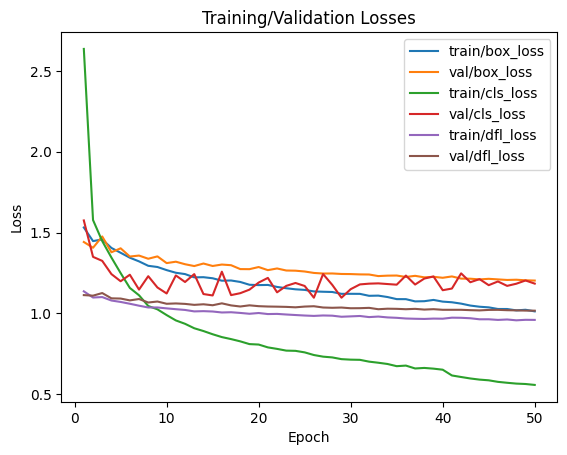

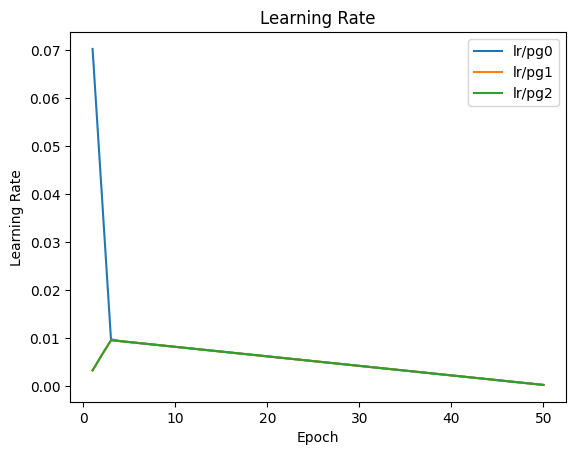

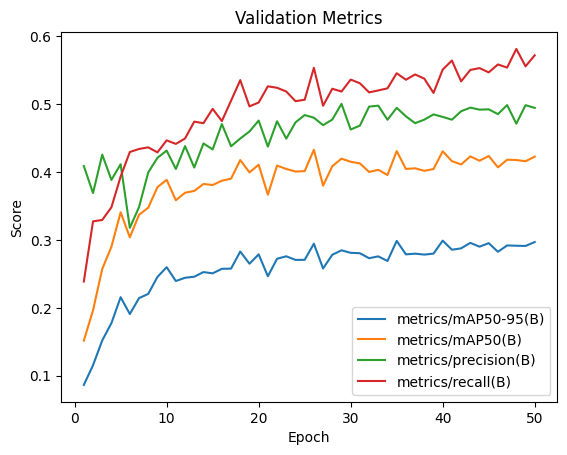

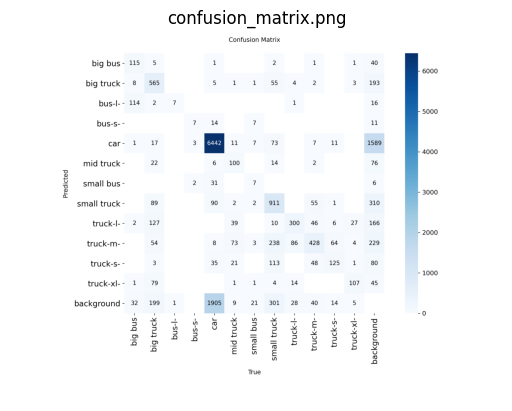

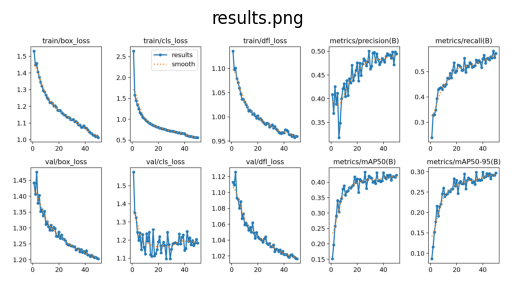

In [32]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

run_dir = Path(RUN_DIR)
csv_path = run_dir / "results.csv"
print("Using:", run_dir)

# 1) Curves from results.csv
if csv_path.exists():
    df = pd.read_csv(csv_path)
    if 'epoch' not in df.columns:
        df.insert(0, 'epoch', np.arange(len(df)))

    plt.figure();
    for col in ['train/box_loss','val/box_loss','train/cls_loss','val/cls_loss','train/dfl_loss','val/dfl_loss']:
        if col in df.columns: plt.plot(df['epoch'], df[col], label=col)
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training/Validation Losses"); plt.legend(); plt.show()

    lr_cols = [c for c in df.columns if 'lr' in c.lower()]
    if lr_cols:
        plt.figure()
        for col in lr_cols: plt.plot(df['epoch'], df[col], label=col)
        plt.xlabel("Epoch"); plt.ylabel("Learning Rate"); plt.title("Learning Rate"); plt.legend(); plt.show()

    plt.figure()
    for k in ["metrics/mAP50-95(B)", "metrics/mAP50(B)", "metrics/precision(B)", "metrics/recall(B)"]:
        if k in df.columns: plt.plot(df['epoch'], df[k], label=k)
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation Metrics"); plt.legend(); plt.show()
else:
    print("No results.csv found in", csv_path)

# 2) Show saved validation plots (if present)
for name in ["PR_curve.png","F1_curve.png","confusion_matrix.png","results.png","labels_correlogram.png","predictions.jpg"]:
    p = run_dir / name
    if p.exists():
        img = Image.open(p)
        plt.figure(); plt.imshow(img); plt.axis('off'); plt.title(name); plt.show()


In [33]:
from google.colab import drive
drive.mount('/content/drive')

# Adjust the path to where IMG_0038.MOV is stored in your Drive
IN_MOV = "/content/drive/MyDrive/Video_H/IMG_0038.MOV"



Mounted at /content/drive


In [34]:
# Re-encode to H.264 video + AAC audio at 30 fps for browser playback in Colab
IN_MP4 = "/content/IMG_0038.mp4"
!ffmpeg -y -i "$IN_MOV" -c:v libx264 -preset veryfast -pix_fmt yuv420p -r 30 -c:a aac -movflags +faststart "$IN_MP4"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [35]:
from ultralytics import YOLO
from pathlib import Path
import torch, os

# Point to your trained weights:
# adjust RUN_NAME if needed (e.g., vehicles_y8n, vehicles_y8n3, etc.)
RUN_NAME = "vehicles_y8n"
BEST_PT = Path(f"/content/runs_yolo8/{RUN_NAME}/weights/best.pt")
assert BEST_PT.exists(), f"best.pt not found at {BEST_PT}"

model = YOLO(str(BEST_PT))

# Inference settings
IMGSZ = 640
CONF  = 0.25
IOU   = 0.45

res = model.predict(
    source="/content/IMG_0038.mp4",
    imgsz=IMGSZ,
    conf=CONF,
    iou=IOU,
    device=0 if torch.cuda.is_available() else "cpu",
    save=True,          # saves annotated video
    save_txt=False,     # set True if you want .txt detections per frame
    save_conf=False,
    project="/content/preds",
    name="veh_demo",
    exist_ok=True
)

# The output video path:
OUT_DIR = Path("/content/preds/veh_demo")
print("Outputs at:", OUT_DIR)
out_videos = list(OUT_DIR.glob("*.mp4")) + list(OUT_DIR.glob("*.avi")) + list(OUT_DIR.glob("*.mov"))
out_videos



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/625) /content/IMG_0038.mp4: 384x640 (no detections), 67.0ms
video 1/1 (frame 2/625) /content/IMG_0038.mp4: 384x640 1 car, 7.7ms
video 1/1 (frame 3/625) /content/IMG_0038.mp4: 384x640 1 car, 7.8ms
video 1/1 (frame 4/625) /content/IMG_0038.mp4: 384x640 1 car, 7.9ms
video 1/1 (frame 5/625) /content/IMG_0038.mp4: 384x640 (no detections), 7.7ms
video 1/1 (frame 6/625) /content/IMG_0038.mp4: 384x640 (no detections), 7.6ms
video 1/1 (frame 

[PosixPath('/content/preds/veh_demo/IMG_0038.avi')]

In [37]:
# If Ultralytics wrote an .avi, convert it to mp4 for Colab playback
from pathlib import Path, PurePath
import subprocess, shutil

candidates = list(Path("/content/preds/veh_demo").glob("*"))
avi = [p for p in candidates if p.suffix.lower()==".avi"]
if avi:
    src = avi[0]
    dst = src.with_suffix(".mp4")
    !ffmpeg -y -i "$src" -c:v libx264 -preset veryfast -pix_fmt yuv420p -r 30 -c:a aac -movflags +faststart "$dst"
    print("Converted to:", dst)
    OUT_MP4 = str(dst)
else:
    # Pick the first mp4 if present
    mp4s = [p for p in candidates if p.suffix.lower()==".mp4"]
    OUT_MP4 = str(mp4s[0]) if mp4s else None

print("Final MP4:", OUT_MP4)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

##Export to ONNX

In [39]:
# ======= PART 1: EXPORT TO ONNX + PACKAGE =======
# Edit only RUN_NAME and IMGSZ if needed.

%pip -q install ultralytics==8.3.189 onnx onnxsim "opencv-python-headless<5.0.0>"

from pathlib import Path
import shutil, glob
from ultralytics import YOLO
import onnx, os

# --- CONFIG ---
RUN_NAME  = "vehicles_y8n"   # your trained run under /content/runs_yolo8/
IMGSZ     = 416              # must match your train/export size (416 or 640)

# --- Locate weights + data.yaml ---
run_dir  = Path(f"/content/runs_yolo8/{RUN_NAME}")
best_pt  = run_dir/"weights/best.pt"
assert best_pt.exists(), f"Missing: {best_pt}"

# try to find your data.yaml automatically if not already in /content/hailo_pkg
hailo_pkg = Path("/content/hailo_pkg"); hailo_pkg.mkdir(exist_ok=True)
data_yaml = hailo_pkg/"data.yaml"
if not data_yaml.exists():
    guesses = list(Path("/content").rglob("data.yaml"))
    assert guesses, "Couldn't find data.yaml. Please place it at /content/hailo_pkg/data.yaml"
    shutil.copy2(guesses[0], data_yaml)

# --- Export ONNX (static, opset 12) ---
print("Exporting ONNX from:", best_pt)
model_pt = YOLO(str(best_pt))
onnx_path = Path(model_pt.export(format="onnx", imgsz=IMGSZ, opset=12, simplify=True, dynamic=False))
print("ONNX:", onnx_path)

# Verify ONNX
m = onnx.load(str(onnx_path)); onnx.checker.check_model(m)
print("ONNX check: OK")

# --- Stage artifacts for Hailo box ---
shutil.copy2(onnx_path, hailo_pkg/"best.onnx")
print("Staged:", hailo_pkg/"best.onnx", "and", data_yaml)

# (optional) build a small calibration set from whatever dataset you have locally
# If you have a dataset mounted, set DATASET_DIR below to enable.
DATASET_DIR = None  # e.g. Path("/content/roboflow/data")
CALIB_DIR   = Path("/content/calib_imgs")
if DATASET_DIR:
    CALIB_DIR.mkdir(exist_ok=True)
    imgs = sorted(glob.glob(str(Path(DATASET_DIR)/"train/images/*")))[:200]
    for p in imgs:
        shutil.copy2(p, CALIB_DIR/Path(p).name)
    print(f"Calibration images copied: {len(list(CALIB_DIR.glob('*')))}")
else:
    print("Skipped calibration set (no DATASET_DIR).")

# --- Zip outputs locally ---
shutil.make_archive("/content/hailo_pkg", "zip", root_dir=hailo_pkg)
if CALIB_DIR.exists():
    shutil.make_archive("/content/calib_imgs", "zip", root_dir=CALIB_DIR)

print("\nArtifacts ready:")
print(" - /content/hailo_pkg.zip  (best.onnx + data.yaml)")
print(" - /content/calib_imgs.zip (if created)")


ERROR: Invalid requirement: 'opencv-python-headless<5.0.0>': Expected end or semicolon (after version specifier)
    opencv-python-headless<5.0.0>
                          ~~~~~~^
Exporting ONNX from: /content/runs_yolo8/vehicles_y8n/weights/best.pt
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs_yolo8/vehicles_y8n/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 16, 3549) (11.7 MB)

ONNX: starting export with onnx 1.19.0 opset 12...
ONNX: slimming with onnxslim 0.1.65...
ONNX: export success ✅ 0.8s, saved as '/content/runs_yolo8/vehicles_y8n/weights/best.onnx' (11.6 MB)

Export complete (1.0s)
Results saved to /content/runs_yolo8/vehicles_y8n/weights
Predict:         yolo predict task=detect model=/content/runs_yolo8/vehicles_y8n/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect model=/c

In [40]:
# ======= PART 2: TEST ONNX ON A LOCAL VIDEO =======
from ultralytics import YOLO
from pathlib import Path
import os, subprocess

INPUT_MP4 = Path("/content/IMG_0038.mp4")           # your local video (already in Colab)
assert INPUT_MP4.exists(), f"Missing input video: {INPUT_MP4}"

ONNX_PATH = Path("/content/hailo_pkg/best.onnx")    # from Part 1
assert ONNX_PATH.exists(), f"Missing ONNX model: {ONNX_PATH}"

# Load the ONNX model (NOT best.pt)
model_onnx = YOLO(str(ONNX_PATH))

# Run inference and save annotated video (Ultralytics chooses a container; we'll ensure MP4)
OUT_DIR   = Path("/content/preds/onnx_video"); OUT_DIR.mkdir(parents=True, exist_ok=True)
res = model_onnx.predict(
    source=str(INPUT_MP4),
    imgsz=416,              # use the same size you exported
    conf=0.25,
    iou=0.45,
    device=0 if os.path.exists("/proc/driver/nvidia/version") else "cpu",
    save=True,
    project=str(OUT_DIR.parent),
    name=OUT_DIR.name,
    exist_ok=True
)

# Find the output and convert to MP4 if needed
outs = list(OUT_DIR.glob("*"))
mp4s = [p for p in outs if p.suffix.lower()==".mp4"]
avis = [p for p in outs if p.suffix.lower()==".avi"]

if mp4s:
    OUT_MP4 = mp4s[0]
elif avis:
    # convert .avi -> .mp4
    OUT_MP4 = avis[0].with_name(avis[0].stem + "_from_onnx.mp4")
    cmd = ["ffmpeg","-y","-i",str(avis[0]),"-c:v","libx264","-preset","veryfast",
           "-pix_fmt","yuv420p","-r","30","-c:a","aac","-movflags","+faststart",str(OUT_MP4)]
    subprocess.run(cmd, check=True)
else:
    OUT_MP4 = None

print("\n=== ONNX Video Test ===")
print("ONNX model :", ONNX_PATH)
print("Input      :", INPUT_MP4)
print("Output MP4 :", OUT_MP4 if OUT_MP4 else "(not found)")

# Inline preview
from IPython.display import HTML
if OUT_MP4 and OUT_MP4.exists():
    display(HTML(f'''
    <video width="800" controls>
      <source src="{OUT_MP4}" type="video/mp4">
    </video>
    '''))



WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/hailo_pkg/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/625) /content/IMG_0038.mp4: 416x416 (no detections), 3.4ms
video 1/1 (frame 2/625) /content/IMG_0038.mp4: 416x416 (no detections), 3.5ms
video 1/1 (frame 

In [42]:
from pathlib import Path
import shutil, zipfile, os

BASE_DIR = Path("/content/hailo_pkg")
assert (BASE_DIR/"best.onnx").exists(), "Missing best.onnx in /content/hailo_pkg"
assert (BASE_DIR/"data.yaml").exists(), "Missing data.yaml in /content/hailo_pkg"

# Rebuild the zip explicitly
zip_path = "/content/hailo_pkg.zip"
# (use zipfile to avoid any edge-cases)
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for p in BASE_DIR.rglob("*"):
        zf.write(p, p.relative_to(BASE_DIR))

# Confirm on disk
p = Path(zip_path)
print("Created:", p, "| exists:", p.exists(), "| size:", p.stat().st_size, "bytes")

# List it so you can see it in output
!ls -lah /content | grep hailo_pkg


Created: /content/hailo_pkg.zip | exists: True | size: 10539835 bytes
drwxr-xr-x 2 root root 4.0K Aug 30 08:14 hailo_pkg
-rw-r--r-- 1 root root  11M Aug 30 08:42 hailo_pkg.zip


In [46]:
from google.colab import files
files.download("/content/hailo_pkg.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
from pathlib import Path
import zipfile, shutil, glob, os

# --- verify hailo_pkg contents ---
BASE = Path("/content/hailo_pkg")
assert (BASE/"best.onnx").exists(), "Missing /content/hailo_pkg/best.onnx"
assert (BASE/"data.yaml").exists(), "Missing /content/hailo_pkg/data.yaml"

# --- rebuild hailo_pkg.zip deterministically ---
ZIP1 = Path("/content/hailo_pkg.zip")
with zipfile.ZipFile(ZIP1, "w", zipfile.ZIP_DEFLATED) as zf:
    for p in BASE.rglob("*"):
        zf.write(p, p.relative_to(BASE))
print("Created:", ZIP1, "| size:", ZIP1.stat().st_size, "bytes")

# --- optional calib zip (only if folder exists) ---
CALIB_DIR = Path("/content/calib_imgs")
if CALIB_DIR.exists() and any(CALIB_DIR.iterdir()):
    ZIP2 = Path("/content/calib_imgs.zip")
    with zipfile.ZipFile(ZIP2, "w", zipfile.ZIP_DEFLATED) as zf:
        for p in CALIB_DIR.rglob("*"):
            zf.write(p, p.relative_to(CALIB_DIR))
    print("Created:", ZIP2, "| size:", ZIP2.stat().st_size, "bytes")
else:
    print("No calibration folder found at /content/calib_imgs (skipping calib_imgs.zip).")

# show files so you can see them in output
!ls -lah /content | egrep "hailo_pkg.zip|calib_imgs.zip"


Created: /content/hailo_pkg.zip | size: 10539835 bytes
No calibration folder found at /content/calib_imgs (skipping calib_imgs.zip).
-rw-r--r-- 1 root root  11M Aug 30 09:24 hailo_pkg.zip


In [48]:
# Source dataset
DATASET_DIR = Path("/content/vehicles-2")
assert DATASET_DIR.exists(), "Dataset not found at /content/vehicles-2"

# Collect images from train/valid/test
all_imgs = []
for split in ["train", "valid", "test"]:
    img_dir = DATASET_DIR / split / "images"
    if img_dir.exists():
        all_imgs.extend(glob.glob(str(img_dir / "*")))

print("Found total images:", len(all_imgs))

# Take 200 random calibration images
random.seed(0)
take = random.sample(all_imgs, min(200, len(all_imgs)))

# Copy to /content/calib_imgs
CALIB_DIR = Path("/content/calib_imgs")
if CALIB_DIR.exists():
    shutil.rmtree(CALIB_DIR)
CALIB_DIR.mkdir(parents=True, exist_ok=True)

for src in take:
    shutil.copy2(src, CALIB_DIR / Path(src).name)

print("Calibration images copied:", len(list(CALIB_DIR.glob('*'))))

# Zip them
ZIP_PATH = "/content/calib_imgs.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zf:
    for p in CALIB_DIR.rglob("*"):
        zf.write(p, p.relative_to(CALIB_DIR))

print("Created calib zip:", ZIP_PATH, "| size:", Path(ZIP_PATH).stat().st_size, "bytes")
!ls -lah /content/calib_imgs.zip


Found total images: 4058
Calibration images copied: 200
Created calib zip: /content/calib_imgs.zip | size: 8704628 bytes
-rw-r--r-- 1 root root 8.4M Aug 30 09:27 /content/calib_imgs.zip
